## 5.10　专题：流形学习
前面已经介绍过如何用主成分分析降维——它可以在减少数据集特征的同时，保留数据点间的必要关系。虽然PCA 是一个灵活、快速且容易解释的算法，但是它对存在非线性关系的数据集的处理效果并不太好，我们将在后面介绍几个示例。为了弥补这个缺陷，我们选择另外一种方法——流形学习（manifold learning）。流形学习是一种无监督评估器，它试图将一个低维度流形嵌入到一个高维度空间来描述数据集。当你思考流形时，建议你设想有一张纸——一个存在于我们所熟悉的三维世界中的二维物体——它可以从两个维度弯折或卷起。提到流形学习这个术语时，可以把这张纸看成那个嵌入三维空间中二维流形。在三维空间中旋转、重定向或者伸展这张纸，都不会改变它的平面几何特性：这些操作和线性嵌入类似。如果你弯折、卷曲或者弄皱这张纸，它仍然是一个二维流形，但是嵌入到一个三维空间就不再是线性的了。流形学习算法将试图学习这张纸的二维特征，包括将纸弯曲后放入一个三维空间中。

这里将深入介绍几种流形方法的技巧，包括
* 多维标度法（multidimensional scaling，MDS）、
* 局部线性嵌入法（locally linear embedding，LLE） 
* 保距映射法（isometric mapping，Isomap）。

首先还是导入标准的程序库：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### 5.10.1　流形学习：“HELLO”
为了使这些概念更清楚，先生成一些二维数据来定义一个流形。下面用函数创建一组数据，构成单词“HELLO”的形状：

In [2]:
def make_hello(N=1000, rseed=42):
    # 画出“HELLO”文字形状的图像，并保存成PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # 打开这个PNG，并将一些随机点画进去
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

调用该函数并且画出结果数据（如图5-94 所示）：

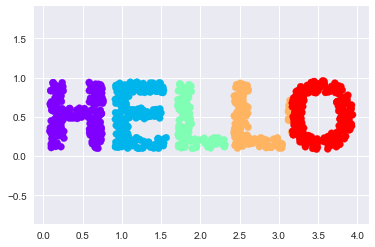

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

输出图像包含了很多二维的点，它们组成了单词“H

### 5.10.2　多维标度法（MDS）
通过观察这个数据集，可以看到数据集中选中的x 值和y 值并不是对数据的最基本描述：即使放大、缩小或旋转数据，“HELLO”仍然会很明显。例如，如果用一个旋转矩阵来旋转数据，x 和y 的值将会改变，但是数据形状基本还是一样的（如图5-95 所示）：

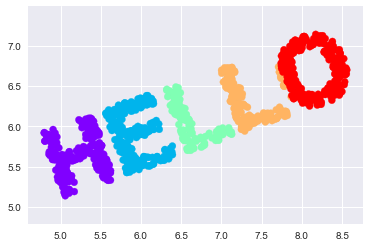

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

这说明x 和y 的值并不是数据间关系的必要基础特征。**这个例子中真正的基础特征是每个点与数据集中其他点的距离。**
<br>表示这种关系的常用方法是**关系（距离）矩阵**：对于N 个点，构建一个N × N 的矩阵，元素(i , j ) 是点i 和点j 之间的距离。
<br>我们用Scikit-Learn 中的pairwise_distances 函数来计算原始数据的关系矩阵：

In [5]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X)
D.shape

(1000, 1000)

正如前面承诺的，对于N = 1000 个点，获得了一个1000 × 1000 的矩阵。画出该矩阵，如图5-96 所示：

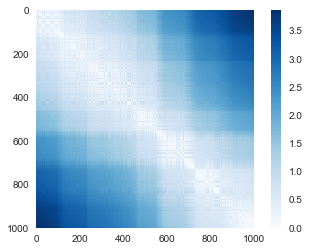

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

如果用类似方法为已经做过旋转和平移变换的数据构建一个距离矩阵，将看到同样的结果：

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

这个距离矩阵给出了一个数据集内部关系的表现形式，这种形式与数据集的旋转和投影无关。但距离矩阵的可视化效果却显得不够直观。图5-96 丢失了我们之前在数据中看到的关于“HELLO”的所有视觉特征。

虽然从(x, y) 坐标计算这个距离矩阵很简单，但是从距离矩阵转换回x 坐标值和y 坐标值却非常困难。这就是多维标度法可以解决的问题：它可以将一个数据集的距离矩阵还原成一个D 维坐标来表示数据集。
<br>下面来看看多维标度法是如何还原距离矩阵的——MDS 模型将非相似性（dissimilarity）参数设置为precomputed 来处理距离矩阵（如图5-97 所示）：

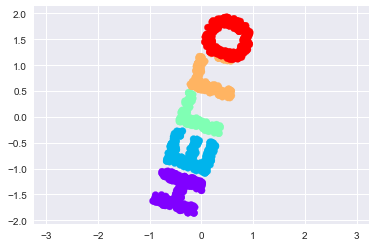

In [8]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

仅仅依靠描述数据点间关系的N × N 距离矩阵，MDS 算法就可以为数据还原出一种可行的二维坐标。

### 5.10.3　将MDS用于流形学习
既然距离矩阵可以从数据的任意维度进行计算，那么这种方法绝对非常实用。既然可以在一个二维平面中简单地旋转数据，那么也可以用以下函数将其投影到三维空间（特别是用前面介绍过的三维旋转矩阵）：

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

将这些点画出来，看看可视化效果（如图5-98 所示）：

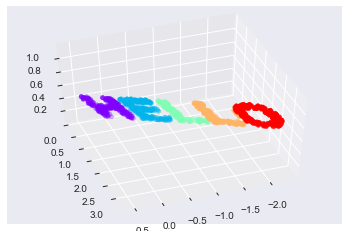

In [10]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

现在可以通过MDS 评估器输入这个三维数据，计算距离矩阵，然后得出距离矩阵的最优二维嵌入结果。结果还原了原始数据的形状（如图5-99 所示）：

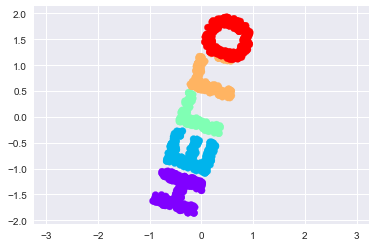

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

以上就是使用流形学习评估器希望达成的基本目标：给定一个高维嵌入数据，寻找数据的一个低维表示，并保留数据间的特定关系。在MDS 的示例中，保留的数据是每对数据点之间的距离。

### 5.10.4　非线性嵌入：当MDS失败时
前面介绍了线性嵌入模型，它包括将数据旋转、平移和缩放到一个高维空间的操作。但是**当嵌入为非线性时，即超越简单的操作集合时，MDS 算法就会失效**。现在看看下面这个将输入数据在三维空间中扭曲成“S”形状的示例：

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

虽然这也是一个三维数据，但是这个嵌入更加复杂（如图5-100 所示）：

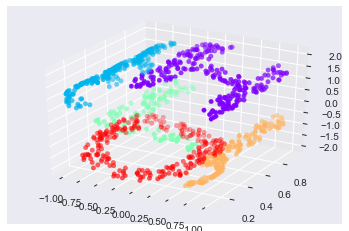

In [13]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

虽然数据点间基本的关系仍然存在，但是这次数据以非线性的方式进行了变换：它被包裹成了“S”形。

如果尝试用一个简单的MDS 算法来处理这个数据，就无法展示数据非线性嵌入的特征，进而导致我们丢失了这个嵌入式流形的内部基本关系特性（如图5-101 所示）：

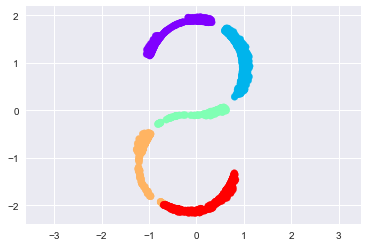

In [14]:
from sklearn.manifold import MDS

model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

即使是最优的二维线性嵌入也不能破解S 曲线的谜题，而且还丢失了原始数据的y 轴信息。

### 5.10.5　非线性流形：局部线性嵌入
那么该如何改进呢？在学习新的内容之前，先来回顾一下问题的源头：**MDS 算法构建嵌入时，总是期望保留相距很远的数据点之间的距离**。但是如果修改算法，让它只保留比较接近的点之间的距离呢？嵌入的结果可能会与我们的期望更接近。

可以将这两种思路想象成图5-102 所示的情况。
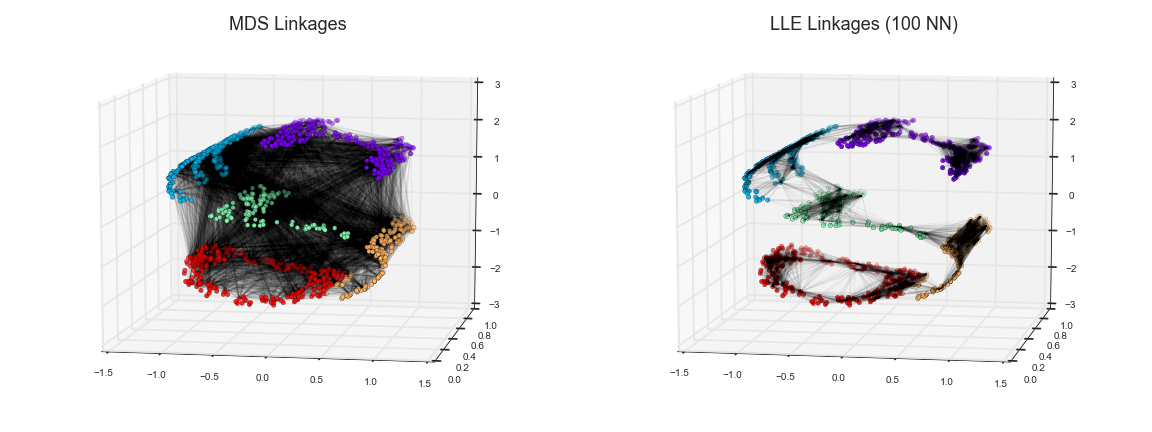

其中每一条细小的线都表示在嵌入时会保留的距离。左图是用MDS 算法生成的嵌入模型，它会试图保留数据集中每对数据点间的距离；右图是用流形学习算法局部线性嵌入（LLE）生成的嵌入模型，该方法不保留所有的距离，而是仅保留邻节点间的距离——本例选择与每个点最近的100 个邻节点。

看看左图，就能够明白为什么MDS 算法会失效了：显然不可能在展开数据的同时，保证每条线段的长度完全不变。相比之下，右图的情况就更乐观一些。我们可以想象着通过某种方式将卷曲的数据展开，并且线段的长度基本保持不变。这就是LLE 算法的工作原理，它通过对成本函数的全局优化来反映这个逻辑。

LLE 有好几种表现形式，这里用modified LLE 算法来还原嵌入的二维流形。通常情况下，modified LLE 的效果比用其他算法还原实现定义好的流形数据的效果好，它几乎不会造成扭曲（如图5-103 所示）：

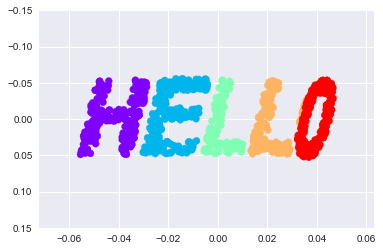

In [15]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

比起原始流形，这个结果虽然出现了一定程度的扭曲，但还是保留了数据的基本关系特性。

### 5.10.6　关于流形方法的一些思考
虽然这个示例十分精彩，但是由于流形学习在实际应用中的要求非常严格，因此除了在对高维数据进行简单的定性可视化之外，流形学习很少被正式使用。
<br>以下是流形学习的一些特殊挑战，并将这些挑战与PCA 算法进行了比较。
* 在流形学习中，并没有好的框架来处理缺失值。相比之下，PCA 算法中有一个用于处理缺失值的迭代方法。
* 在流形学习中，数据中噪音的出现将造成流形“短路”，并且严重影响嵌入结果。相比之下，PCA 可以自然地从最重要的成分中滤除噪音。
* 流形嵌入的结果通常高度依赖于所选取的邻节点的个数，并且通常没有确定的定量方式来选择最优的邻节点个数。相比之下，PCA 算法中并不存在这样的问题。
* 在流形学习中，全局最优的输出维度数很难确定。相比之下，PCA 可以基于解释方差来确定输出的维度数。
* 在流形学习中，嵌入维度的含义并不总是很清楚；而在PCA 算法中，主成分有非常明确的含义。
* 在流形学习中，流形方法的计算复杂度为O[N2] 或O[N3]。而PCA 可以选择随机方法，通常速度更快（详情请参见megaman 程序包中的一些具有可扩展能力的流形学习实现）。

虽然以上列举的都是流形学习相比于PCA 算法的缺点，但是流形学习还有一个明显的优点，那就是它具有保留数据中的非线性关系的能力。正因为这个原因，我通常的做法是：
先用PCA 探索数据的线性特征，再用流形方法探索数据的非线性特征。
除了Isomap 和LLE，Scikit-Learn 还实现了其他几个常见的流形学习方法：Scikit-Learn 文档有一篇非常精彩的流形学习算法对比文章（http://scikit-learn.org/stable/modules/manifold.html ）。

基于我的个人经验，给出以下几点建议。
* LLE 在sklearn.manifold.LocallyLinearEmbedding 中实现。它对于简单问题，例如前面介绍过的S 曲线、局部线性嵌入（LLE）及其变体（特别是modified LLE）的学习效果非常好。
* Isomap 在sklearn.manifold.Isomap 中实现。虽然LLE 通常对现实世界的高维数据源的学习效果比较差，但是Isomap 算法往往会获得比较好的嵌入效果。
* t- 分布邻域嵌入算法（t-distributed stochastic neighbor embedding，t-SNE）在sklearn.manifold.TSNE 中实现。将它用于高度聚类的数据效果比较好，但是该方法比其他方法学习速度慢。

如果你对这些方法的工作方式感兴趣，那么我建议你用本节的数据运行这些方法，进而进
行对比。

### 5.10.7　示例：用Isomap处理人脸数据
流形学习经常被用于探索高维数据点内部的关系。常见的高维数据示例就是图像数据。例如，一组1000 像素的图像经常被看成是1000 维度的点集合，每幅图像中每一个像素的亮度信息定义了相应维度上的坐标值。
<br>这次我们将用Isomap 方法处理一些人脸数据——使用Wild 数据集中带标签的人脸数据，这个数据集在5.9 节已经出现过。执行以下命令就会下载数据，并将其保存到代码同目录下，供后续使用：

In [17]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2241, 2914)

我们有2370 幅图像，每一幅图像有2914 个像素。换句话说，这些图像可以被看成是一个2914 维空间中的数据点的集合！

先将几幅图像进行快速可视化，看看要处理的数据（如图5-104 所示）：

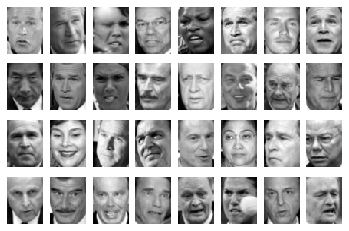

In [19]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

我们希望画出这2914 维数据的一个低维嵌入结果，以此来了解图像的基本关系。可以从计算PCA 开始，从而查看解释方差的比率。通过这个比率，就可以判断需要多少线性特征才能描述数据（如图5-105 所示）：

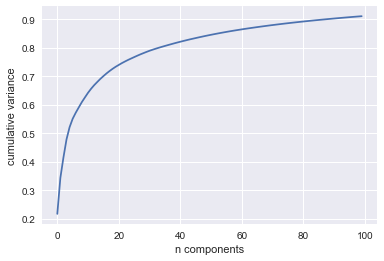

In [21]:
from sklearn.decomposition import PCA

model = PCA(100, svd_solver='randomized').fit(faces.data)

plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

我们发现，这个数据大约需要100 个成分才能保存90% 的方差，说明该数据所需的维度非常高，仅通过几个线性成分无法描述。

由于存在上述问题，因此非线性流形嵌入方法，如LLE 和Isomap，就可以派上用场了。用前面的方法对这些人脸数据计算一个Isomap 嵌入：

In [22]:
from sklearn.manifold import Isomap

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2241, 2)

输出的是对所有图像的一个二维投影。为了更好地理解该投影表示的含义，来定义一个函数，在不同的投影位置输出图像的缩略图：

In [23]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 不展示相距很近的点
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                proj[i])
            ax.add_artist(imagebox)

调用这个函数后，就可以看到以下结果（如图5-106 所示）：

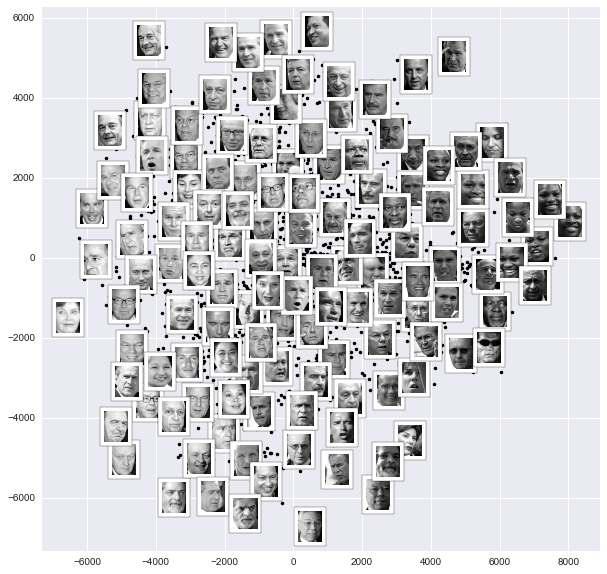

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
model=Isomap(n_components=2),
images=faces.images[:, ::2, ::2])

结果非常有趣。前两个Isomap 维度仿佛就描述了图像的整体特征：图像明暗度从左至右持续变化，人脸朝向从下到上持续变化。这是一组非常好的视觉指标，呈现了数据中一些基本特征。我们可以根据这个结果将数据进行分类，并像5.7 节做过的那样，用流形特征作为分类算法的输入数据。

### 5.10.8　示例：手写数字的可视化结构
本例是另外一个使用流形学习进行可视化的例子，用到的是MNIST 手写数字数据集。该数据和我们在5.8 节中看到的数字类似，但是每幅图像包含的像素更多。它可以用Scikit-Learn 工具从http://mldata.org/ 下载：

In [ ]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist.data.shape

它包含了70 000 幅图像，每幅图像有784 像素（也就是说，图像是28 像素 × 28 像素）。与前面的处理方式相同，先看看前面几幅图像（如图5-107 所示）：

In [ ]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

这样就能对数据集中的各种手写方式有个直观印象了。

下面来计算这些数据的流形学习投影，如图5-108 所示。考虑到计算速度的影响，我们仅使用数据集的1/30 进行学习，大概包括2000 个数字样本点（由于流形学习的计算扩展性比较差，因此一开始用几千个示例数据也许是不错的选择，这样可以在完整计算之前进行相对快速的探索）：

In [ ]:
# 由于计算完整的数据集需要花很长时间，因此仅使用数据集的1/30
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

该散点图结果展示了数据点间的一些关系，但是点的分布有一点拥挤。我们可以一次只查看一个数字，来获得更清楚的结果（如图5-109 所示）：

In [ ]:
from sklearn.manifold import Isomap

# 选择1/4的数字"1"来投影
data = mnist.data[mnist.target == 1][::4]
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

结果表明，数据集中数字“1”的形式是多种多样的。这个数据在投影空间中分布在一个较宽的曲面上，都像是沿着数字的方向。当你沿着图像向上看，将发现一些带着“帽子”且/ 或带有“底座”的数字“1”，虽然这些形式在整个数据集中非常少。可见，流形投影可以让我们发现数据中的异常点（即邻近的数字片段被偷偷放入抽取的图像中）。

虽然这种方法可能对数字分类任务并没有帮助，但是它确实可以帮助我们更好地理解数据，并且能提供一些进一步分析数据的线索。例如，在构建分类管道模型之前，该如何对数据进行预处理。